In [39]:
import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 
from sklearn.metrics.pairwise import linear_kernel
import boto

In [40]:
from helpers import *

In [41]:
def add(x, y):
    return x + y

In [42]:
add = lambda x, y: x + y

In [43]:
##Loading the Data 

reviews= pd.read_csv('https://data-bootcamp-x399.s3.us-east-2.amazonaws.com/Reviews.csv')
reviews_subset = reviews[:1000]
reviews_sub=pd.DataFrame(reviews_subset)
reviews_sub.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [55]:
reviews['ProductId'].value_counts()

B007JFMH8M    913
B002QWP8H0    632
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
             ... 
B001SCEJ74      1
B0022N9YN2      1
B000F0BXA6      1
B007TAS8KI      1
B000RHXL6G      1
Name: ProductId, Length: 74258, dtype: int64

In [89]:
top_item_df=reviews[reviews.ProductId=="B007JFMH8M"]
top_item_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
562970,562971,B007JFMH8M,A368Z46FIKHSEZ,"jaimoi ""Appreciator of good music""",0,0,5,1343433600,Delicious!,I love these cookies! Not only are they healt...
562971,562972,B007JFMH8M,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",0,0,5,1343433600,Great Anytime of Day!,Quaker Soft Baked Oatmeal Cookies with raisins...
562972,562973,B007JFMH8M,A2Z9JNXPIEL2B9,carwash169,0,0,5,1343433600,Very good!,I am usually not a huge fan of oatmeal cookies...
562973,562974,B007JFMH8M,A31CYJQO3FL586,"P. Titus ""Knitgirlll""",0,0,5,1343433600,Quaker Oats Oatmeal Raisin Mom Voxbox Review C...,I participated in a product review that includ...
562974,562975,B007JFMH8M,A2KXQ2EKFF3K2G,Jessica,0,0,5,1343433600,"Quick, simple HEALTHY snack for the kiddos!!!",My kids loved these. I was very pleased to giv...


In [106]:
#Analyzing text with TF-IDF

stopwords = ENGLISH_STOP_WORDS.union(['br', 'don', 've',' br', 'BR']) #Adding in these after the 1st round, we learned that some of the words were repeated... 
vect = TfidfVectorizer(stop_words=stopwords, max_df=0.50, min_df=2)
X = vect.fit_transform(top_item_df.Text)

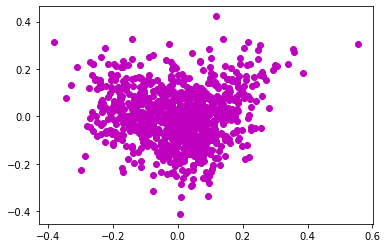

In [107]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [108]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [109]:
features = vect.get_feature_names()
top_words = (top_feats_in_doc(X, features, 1, 10))

top_words.head(20)

top_words["Indexes"]= top_words["features"].str.find(" br")

top_words

,features,score,Indexes
0,day,0.272043,-1
1,following,0.267255,-1
2,dinner,0.233554,-1
3,glass,0.198261,-1
4,need,0.177018,-1
5,texture,0.144917,-1
6,fashioned,0.133627,-1
7,evening,0.133627,-1
8,mg,0.133627,-1
9,150,0.127906,-1


### Clustering with KMeans 


In [130]:
n_clusters = 8
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

In [131]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

In [132]:
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels] 

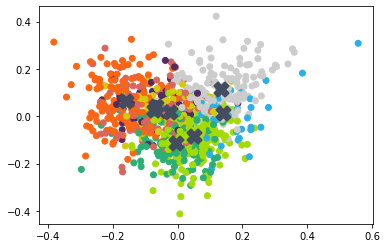

In [133]:
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()


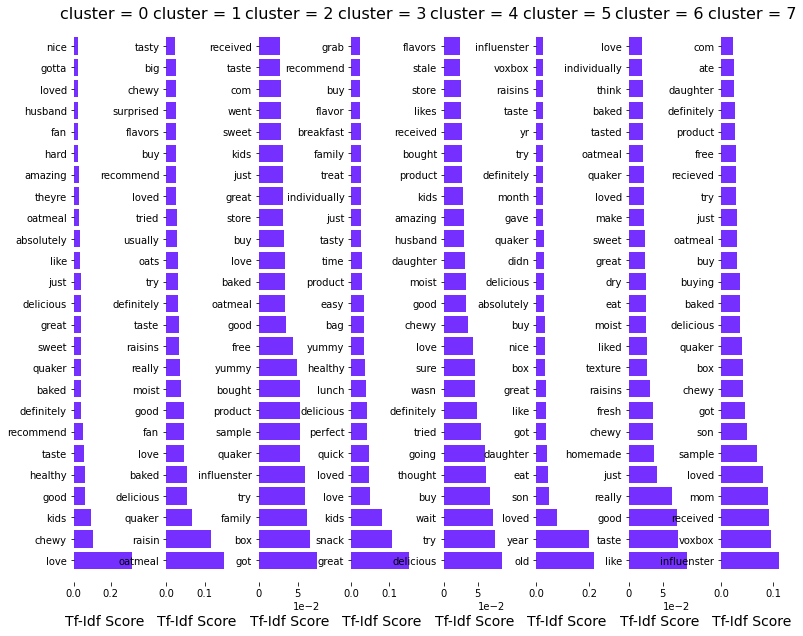

In [134]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

### Finding Related Messages 

In [99]:
vec_train = vect.fit_transform(top_item_df.Text)
# print out the vector of the first email
print(vec_train[0:1])

  (0, 611)	0.46285375454285704
  (0, 470)	0.44470815060644475
  (0, 33)	0.506498157000323
  (0, 280)	0.28702035242981067
  (0, 467)	0.22397596381038454
  (0, 1052)	0.21772015933002248
  (0, 494)	0.31835116526855717
  (0, 627)	0.22397596381038454


In [100]:
cosine_sim = linear_kernel(vec_train[0:1], vec_train).flatten()
# print out the cosine similarities
print(cosine_sim)

[1.         0.0620815  0.0501357  0.03436284 0.1523754  0.06298304
 0.03299176 0.03854392 0.04898009 0.         0.         0.04522633
 0.         0.         0.06130231 0.0739724  0.13128129 0.07563954
 0.03025177 0.         0.         0.05234234 0.03331349 0.06754789
 0.         0.08259246 0.09288428 0.09434003 0.         0.
 0.03381908 0.01402541 0.02318815 0.         0.         0.
 0.07143006 0.01097768 0.08561524 0.05749814 0.         0.
 0.10690578 0.         0.01744613 0.         0.02419215 0.15369903
 0.01319085 0.08773493 0.         0.09434987 0.03404202 0.
 0.07753555 0.02462464 0.05210719 0.07973243 0.         0.0386575
 0.07992887 0.08439253 0.02852317 0.08188537 0.04653961 0.02529793
 0.04305748 0.         0.04506613 0.07374743 0.03299252 0.03557748
 0.09401422 0.10649221 0.09350042 0.         0.         0.10142465
 0.         0.         0.08512329 0.01862354 0.12472815 0.09058585
 0.08644916 0.04724375 0.09597366 0.07591006 0.0710849  0.07409102
 0.         0.         0.   

In [101]:
query = "influenster"

In [102]:
vec_query = vect.transform([query])

In [103]:
cosine_sim = linear_kernel(vec_query, vec_train).flatten()

In [104]:
# Find top 10 most related emails to the query.
related_email_indices = cosine_sim.argsort()[:-10:-1]
# print out the indices of the 10 most related emails.
print(related_email_indices)

[849 869 486 798  58 552 201 426 173]


In [105]:
# print out the first email 
first_email_index = related_email_indices[0]

849
